In [16]:
import warnings
warnings.filterwarnings('ignore')

# PINN investigation

## Vanilla PINN for non chaotic parameters 

In [17]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import pinn
import neural_networks as nns
import helper_functions as hf
import pinn_helper_functions as phf

### Vanilla PINN configuration

In [18]:
# ──────────────── Global configuration ────────────────
# Lorenz system parameter
A = 1.0
B = 1.0
C = 1.0

INITIAL_CONDITIONS = np.array([1.0, 1.0, 1.0], dtype=np.float32)

# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 5000 #25000
COLLOCATION_POINTS = 1024
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

### Comparision Vanilla PINN without and with normalization of the input time vector

In [19]:
# Create RK-45 reference solution
t_eval, sol_rk45 = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)

In [20]:
# Create PINN model without normalization
model_unnorm = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [21]:
pinn.train(
    model_unnorm,
    t_initial=t_min,
    initial_conditions=INITIAL_CONDITIONS,
    A=A, B=B, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=False,
    t_data=None,
    y_data=None
)
y_pinn_unnorm = pinn.pinn_predict(model_unnorm, t_eval, t_min, t_max, normalize_input=False)

Training started...
Epoch 0 Loss: 0.5942535996437073 | IC-Loss: 1.0 | Physics-Loss: 0.18850716948509216
Epoch 1000 Loss: 1.7359670891892165e-05 | IC-Loss: 3.751160093656836e-08 | Physics-Loss: 3.468183058430441e-05
Epoch 2000 Loss: 1.1280536455160473e-05 | IC-Loss: 1.4164746708900111e-08 | Physics-Loss: 2.2546908439835533e-05
Epoch 3000 Loss: 1.1214086953259539e-05 | IC-Loss: 1.0049102883158412e-08 | Physics-Loss: 2.2418123990064487e-05
Epoch 4000 Loss: 1.0467499123478774e-05 | IC-Loss: 9.271441392399993e-09 | Physics-Loss: 2.0925726857967675e-05
Training finished!


In [22]:
# Create PINN model without normalization
model_norm = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [23]:
pinn.train(
    model_norm,
    t_initial=t_min,
    initial_conditions=INITIAL_CONDITIONS,
    A=A, B=B, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=False,
    t_data=None,
    y_data=None
    )
y_pinn_norm = pinn.pinn_predict(model_norm, t_eval, t_min, t_max, normalize_input=True)

Training started...
Epoch 0 Loss: 0.5000017881393433 | IC-Loss: 1.0 | Physics-Loss: 3.609073928600992e-06
Epoch 1000 Loss: 2.140016295015812e-05 | IC-Loss: 7.125979806232863e-08 | Physics-Loss: 4.2729065171442926e-05
Epoch 2000 Loss: 1.6274994777631946e-05 | IC-Loss: 3.122256586607364e-08 | Physics-Loss: 3.251876842114143e-05
Epoch 3000 Loss: 1.422262630512705e-05 | IC-Loss: 1.917483949398502e-08 | Physics-Loss: 2.8426078642951325e-05
Epoch 4000 Loss: 1.3586608474724926e-05 | IC-Loss: 2.461471559911388e-08 | Physics-Loss: 2.714860238484107e-05
Training finished!


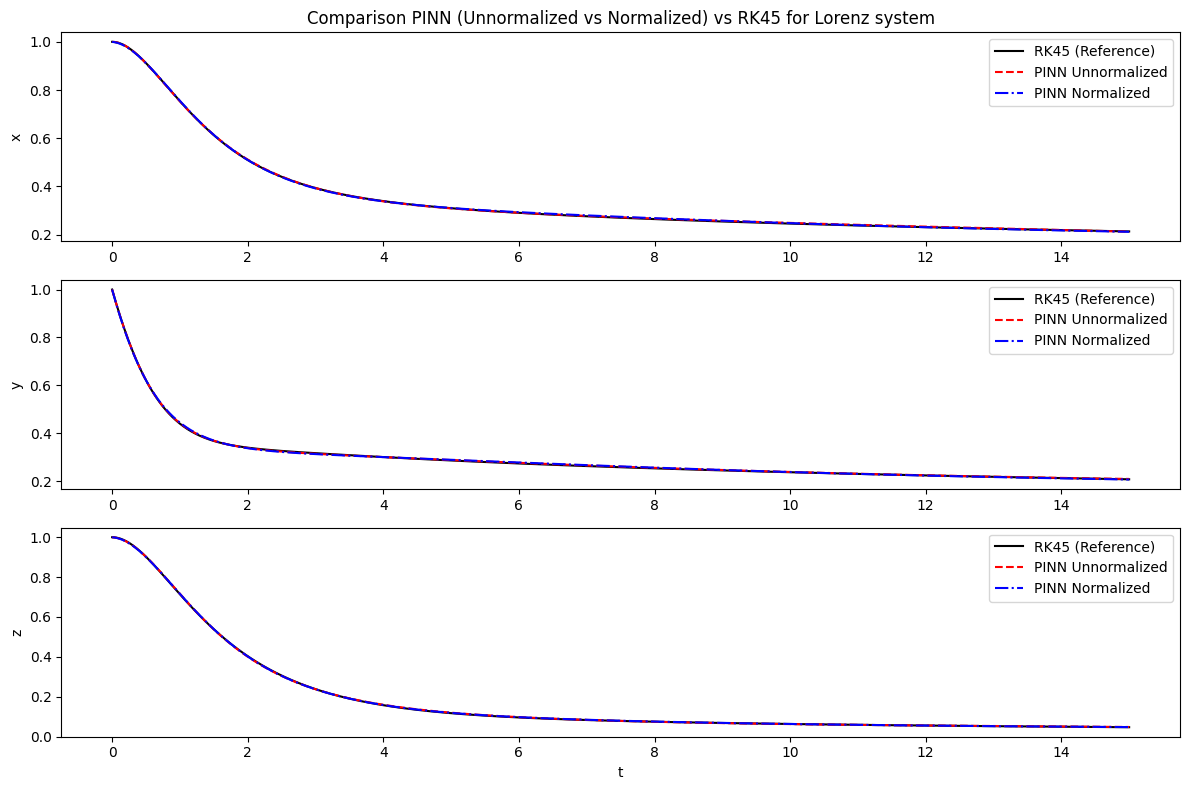

In [24]:
plt.figure(figsize=(12, 8))
labels = ['x', 'y', 'z']

for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t_eval, sol_rk45.y[i], 'k-', label="RK45 (Reference)")
    plt.plot(t_eval, y_pinn_unnorm[:, i], 'r--', label="PINN Unnormalized")
    plt.plot(t_eval, y_pinn_norm[:, i], 'b-.', label="PINN Normalized")
    plt.ylabel(labels[i])
    if i == 0:
        plt.title("Comparison PINN (Unnormalized vs Normalized) vs RK45 for Lorenz system")
    if i == 2:
        plt.xlabel("t")
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

Implementierung zeigt, keine großen Unterschiede zwischen PINN-Modell mit normalisierten Inputvektor und nicht-normalisierten Input-Vektor

## PINN Vergleich gegen Vanilla NN und Vanilla NN mit L2-Regulierung

### Neuronale Netze trainiert mit verrauschten Daten

In [25]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000,
    decay_rate=DECAY_RATE)

# Standard NN und NN mit L2-Regulierung erstellen
nn_model = nns.build_standard_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE,), loss='mse')

nn_l2_model = nns.build_l2_regularized_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_l2_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE), loss='mse')

# Vanilla PINN mit Normalisierung und data loss erstellen
pinn_model = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [26]:
# Verrauschte Daten generieren
t_eval, sol = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)
t_data, y_data = hf.generate_noisy_data(sol, t_min, t_max)

In [27]:
# Modelle auf verrauschten Daten trainieren
nn_model.fit(t_data, y_data, epochs=EPOCHS)
nn_l2_model.fit(t_data, y_data, epochs=EPOCHS)
pinn.train(
    pinn_model,
    t_initial=t_min,
    initial_conditions=INITIAL_CONDITIONS,
    A=A, B=B, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data
)

Epoch 1/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1151
Epoch 2/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0462 
Epoch 3/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0328 
Epoch 4/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0267 
Epoch 5/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0192 
Epoch 6/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 
Epoch 7/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0131 
Epoch 8/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0161 
Epoch 9/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132 
Epoch 10/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116 
Epoch 11/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 
Epoch 12/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 
Epoch 13/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 
Epoch 14/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 
Epoch 15/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 
Epoch

In [28]:
# Modellergebnisse vorhersagen und plotten
y_nn = pinn.pinn_predict(nn_model, t_eval, t_min, t_max, normalize_input=False)
y_l2_nn = pinn.pinn_predict(nn_l2_model, t_eval, t_min, t_max, normalize_input=False)
y_pinn = pinn.pinn_predict(pinn_model, t_eval, t_min, t_max, normalize_input=False)

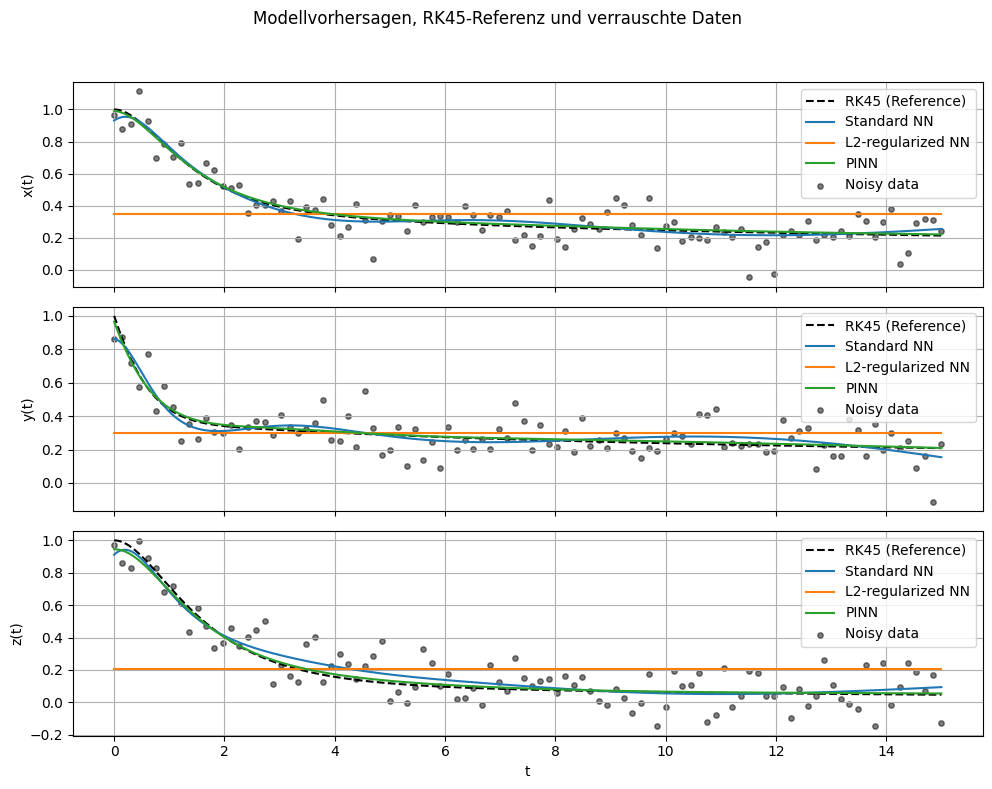

In [29]:
t_plot = t_eval.flatten()

# Noisy Daten vorbereiten
t_data_np = t_data.numpy().flatten()
y_data_np = y_data.numpy()

labels = ['x(t)', 'y(t)', 'z(t)']
models = ['Standard NN', 'L2-regularized NN', 'PINN']
predictions = [y_nn, y_l2_nn, y_pinn]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i in range(3):  # Für x, y, z
    # Referenzlösung (RK45) plotten
    axs[i].plot(t_eval, sol_rk45.y[i], 'k--', label="RK45 (Reference)")

    # Modellvorhersagen plotten
    for j, y in enumerate(predictions):
        axs[i].plot(t_plot, y[:, i], label=models[j])

    # Noisy Daten plotten
    axs[i].scatter(t_data_np, y_data_np[:, i], color='black', s=15, alpha=0.5, label='Noisy data')

    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('t')
plt.suptitle("Modellvorhersagen, RK45-Referenz und verrauschte Daten")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Neuronale Netze trainiert mit unvollständigen Daten

In [30]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000,
    decay_rate=DECAY_RATE)

# Standard NN und NN mit L2-Regulierung erstellen
nn_model = nns.build_standard_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE,), loss='mse')

nn_l2_model = nns.build_l2_regularized_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_l2_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE), loss='mse')

# Vanilla PINN mit Normalisierung und data loss erstellen
pinn_model = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [31]:
# Unvollständige Daten generieren
t_eval, sol = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)
t_data, y_data = hf.generate_noisy_data(sol, t_min, t_max)
t_data_gap, y_data_gap = hf.generate_noisy_data_with_gap(sol, t_min, t_max, 4, 7)

In [32]:
# Modelle auf verrauschten Daten trainieren
nn_model.fit(t_data_gap, y_data_gap, epochs=EPOCHS, batch_size=32) # batch size so training isn't done on all of the collocation points
nn_l2_model.fit(t_data_gap, y_data_gap, epochs=EPOCHS, batch_size=32) # batch size so training isn't done on all of the collocation points
pinn.train(
    pinn_model,
    t_initial=t_min,
    initial_conditions=INITIAL_CONDITIONS,
    A=A, B=B, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data_gap,
    y_data=y_data_gap
)

Epoch 1/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1293
Epoch 2/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0753
Epoch 3/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0447
Epoch 4/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0321
Epoch 5/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0235
Epoch 6/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150
Epoch 7/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139 
Epoch 8/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129
Epoch 9/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0116
Epoch 10/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142 
Epoch 11/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0124
Epoch 12/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113
Epoch 13/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113
Epoch 14/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115
Epoch 15/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 
Epoc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095
Epoch 129/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097
Epoch 130/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095
Epoch 131/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087
Epoch 132/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0094
Epoch 133/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088
Epoch 134/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091
Epoch 135/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098
Epoch 136/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0094
Epoch 137/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092
Epoch 138/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0093
Epoch 139/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0090
Epoch 140/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 
Epoch 141/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092
Epoch 142/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0

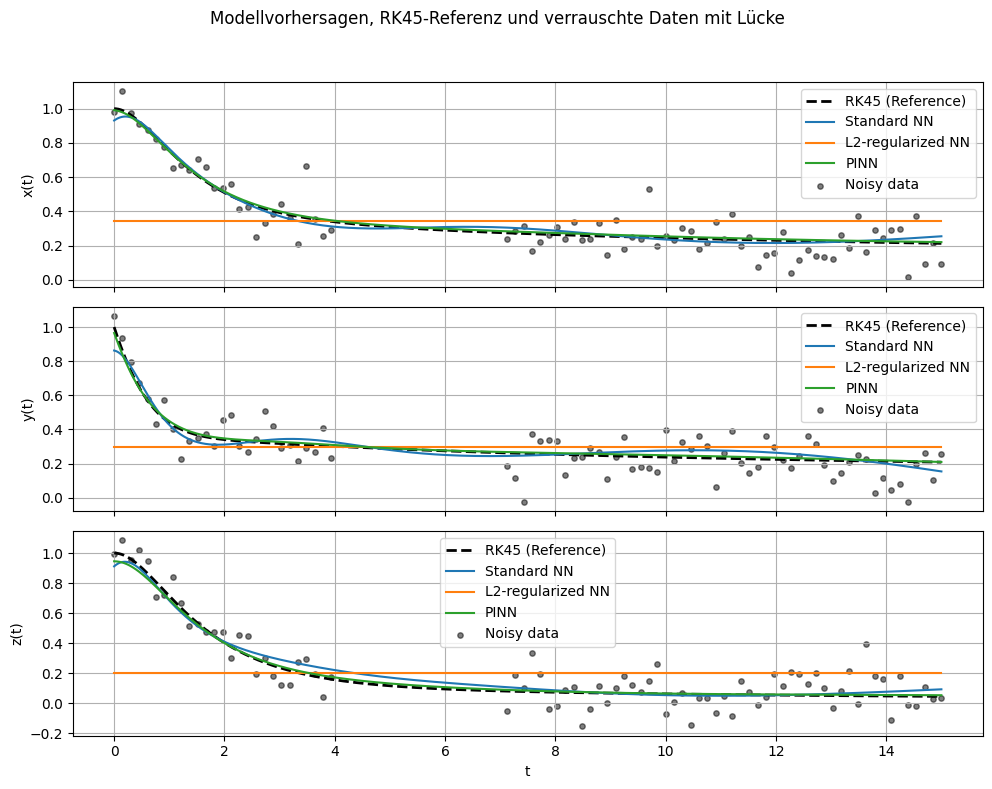

In [33]:
t_plot = t_eval.flatten()

# Noisy Daten mit Lücke vorbereiten
t_data_np = t_data_gap.numpy().flatten()
y_data_np = y_data_gap.numpy()

labels = ['x(t)', 'y(t)', 'z(t)']
models = ['Standard NN', 'L2-regularized NN', 'PINN']
predictions = [y_nn, y_l2_nn, y_pinn]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i in range(3):  # Für x, y, z
    # Referenzlösung (RK45) hinzufügen
    axs[i].plot(t_eval, sol_rk45.y[i], 'k--', linewidth=2, label="RK45 (Reference)")
    
    # Modellvorhersagen plotten
    for j, y in enumerate(predictions):
        axs[i].plot(t_plot, y[:, i], label=models[j])
    
    # Noisy Daten mit Lücke plotten
    axs[i].scatter(t_data_np, y_data_np[:, i], color='black', s=15, alpha=0.5, label='Noisy data')
    
    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('t')
plt.suptitle("Modellvorhersagen, RK45-Referenz und verrauschte Daten mit Lücke")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Neuronale Netze trainiert mit teilweise vorhandenen Daten

In [35]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000,
    decay_rate=DECAY_RATE)

# Standard NN und NN mit L2-Regulierung erstellen
nn_model = nns.build_standard_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE,), loss='mse')

nn_l2_model = nns.build_l2_regularized_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_l2_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE), loss='mse')

# Vanilla PINN mit Normalisierung und data loss erstellen
pinn_model = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [36]:
# Teilweise vorhandene Daten generieren
t_eval, sol = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)
t_data, y_data = hf.generate_noisy_data(sol, t_min, t_max)
y_data_part = hf.generate_partial_noisy_data(y_data, column='x')

Test


In [37]:
# Modelle auf teilweise vorhandenen Daten trainieren
nn_model.fit(t_data, y_data_part, epochs=EPOCHS, batch_size=32) # batch size so training isn't done on all of the collocation points
nn_l2_model.fit(t_data, y_data_part, epochs=EPOCHS, batch_size=32) # batch size so training isn't done on all of the collocation points
pinn.train(
    pinn_model,
    t_initial=t_min,
    initial_conditions=INITIAL_CONDITIONS,
    A=A, B=B, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data_part
)

Epoch 1/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1372
Epoch 2/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0551 
Epoch 3/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0395 
Epoch 4/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0313 
Epoch 5/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0189 
Epoch 6/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0187 
Epoch 7/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0153 
Epoch 8/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 
Epoch 9/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161 
Epoch 10/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166 
Epoch 11/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0170 
Epoch 12/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 
Epoch 13/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 
Epoch 14/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 
Epoch 15/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0137 
Epoch

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


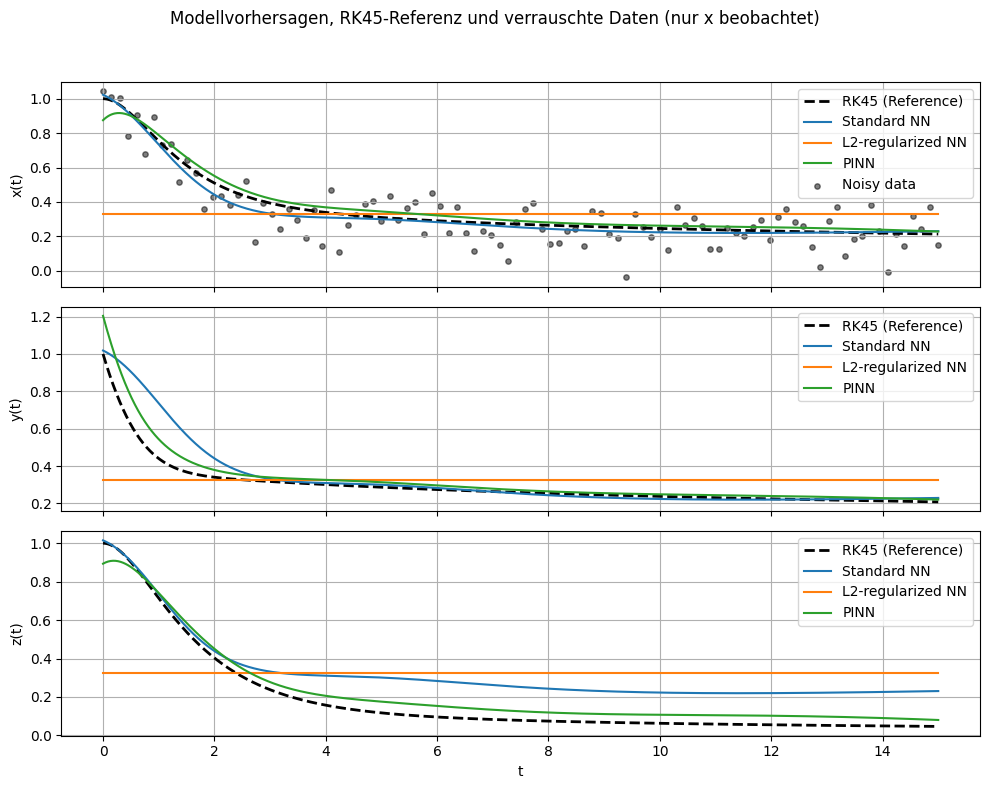

In [39]:
t_plot = t_eval.flatten()

y_nn = nn_model.predict(t_eval)
y_l2_nn = nn_l2_model.predict(t_eval)
y_pinn = pinn_model.predict(t_eval)

predictions = [y_nn, y_l2_nn, y_pinn]

t_data_np = t_data.numpy().flatten()
y_data_np = y_data_part.numpy()

labels = ['x(t)', 'y(t)', 'z(t)']
models = ['Standard NN', 'L2-regularized NN', 'PINN']

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i in range(3):  # x, y, z
    axs[i].plot(t_eval, sol_rk45.y[i], 'k--', linewidth=2, label="RK45 (Reference)")

    for j, y in enumerate(predictions):
        axs[i].plot(t_plot, y[:, i], label=models[j])
    
    if i == 0:
        axs[i].scatter(t_data_np, y_data_np[:, 0], color='black', s=15, alpha=0.5, label='Noisy data')

    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('t')
plt.suptitle("Modellvorhersagen, RK45-Referenz und verrauschte Daten (nur x beobachtet)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
